## Demonstrate rapid search of GB signal
- Data: TDC II-0.1 verification dataset with VGBs. 
- Template: ``TDIFly`` waveform model 
- Methods: $\mathcal{F}$-statistics and differetial evolution optimization

In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.TDI import *
from Triangle.GW import *
from Triangle.TDIFly import * 

import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'
import matplotlib.pyplot as plt

import multiprocessing
if __name__ == "__main__":
    multiprocessing.set_start_method("fork")

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


no cupy 


In [2]:
DATA_DIR = "/Users/taijidatacenter/workspace/TDCData/0_1_VGB_TDIXYZ.h5"
PARAM_DIR = "/Users/taijidatacenter/workspace/TDCData/0_1_VGB_parameters.h5"
ORBIT_DIR = "../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB"

## Load TDI data and true parameters

### Time-domain data and parameters 

In [3]:
with h5py.File(DATA_DIR, "r") as h5file: 
    data_dict = read_dict_from_h5(h5file["/"])

with h5py.File(PARAM_DIR, "r") as h5file: 
    inject_parameters = read_dict_from_h5(h5file["/"])

data_dict.keys(), inject_parameters.keys()

(dict_keys(['XYZ', 'time']),
 dict_keys(['A', 'f0', 'fdot0', 'inclination', 'latitude', 'longitude', 'phase0', 'psi']))

In [4]:
dt = data_dict["time"][1] - data_dict["time"][0]

# pad data to start from t=0
data_time_pad = np.arange(start=0., stop=data_dict["time"][0], step=dt)
data_time = np.concatenate((data_time_pad, data_dict["time"]))

Tobs = len(data_time) * dt 

A_data, E_data, _ = AETfromXYZ(data_dict["XYZ"]["X2"], data_dict["XYZ"]["Y2"], data_dict["XYZ"]["Z2"])
data_channels_td = np.zeros((2, len(data_time)))
data_channels_td[0][len(data_time_pad):] = A_data
data_channels_td[1][len(data_time_pad):] = E_data

channel_names = ["A", "E"]

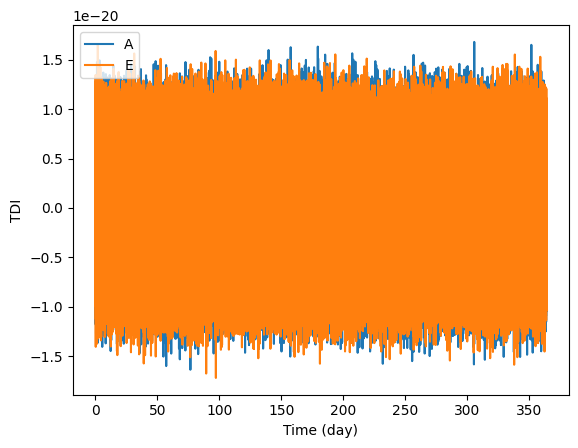

In [5]:
for i in range(len(data_channels_td)):
    plt.plot(data_time/DAY, data_channels_td[i], label=channel_names[i])
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper left")

### Fourier transform 

In [6]:
data_channels_fd = [] 
for i in range(len(data_channels_td)): 
    ff, xf = FFT_window(
        data_array=data_channels_td[i], 
        fsample=1./dt, 
        window_type="tukey", 
        window_args_dict=dict(alpha=10000/Tobs), 
    )
    data_channels_fd.append(xf)
data_frequency = ff 
data_channels_fd = np.array(data_channels_fd) 

(0.0001, 0.05)

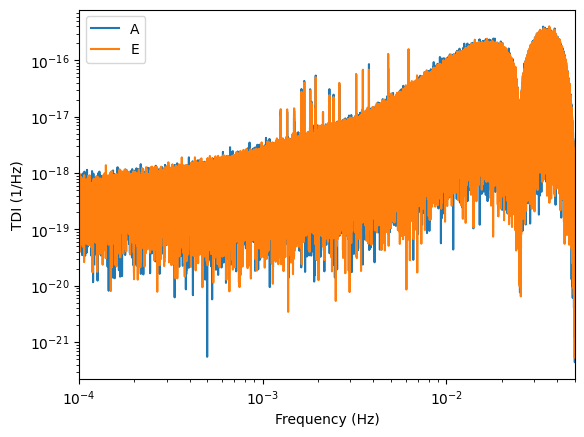

In [7]:
for i in range(len(data_channels_fd)):
    plt.loglog(data_frequency, np.abs(data_channels_fd[i]), label=channel_names[i]) 
plt.xlabel("Frequency (Hz)")
plt.ylabel("TDI (1/Hz)")
plt.legend(loc="upper left")
plt.xlim(1e-4, 0.05)

### select a freuqncy band to be analyzed 

In [8]:
# select HmCNC
analyze_gb_idx = 0 

true_gb_parameters = {key: inject_parameters[key][analyze_gb_idx] for key in inject_parameters.keys()} 
true_gb_parameters

{'A': 4.252225600012621e-23,
 'f0': 0.0062202762350654,
 'fdot0': 7.4852687317337495e-16,
 'inclination': 0.6632251157578452,
 'latitude': -0.0820999173027218,
 'longitude': 2.102051345707588,
 'phase0': 4.321297602415225,
 'psi': 2.1242599437830183}

In [9]:
band_width = 5e-6 

band_idx = np.where((data_frequency <= true_gb_parameters["f0"] + band_width/2)&(data_frequency >= true_gb_parameters["f0"] - band_width/2))[0]
data_frequency = data_frequency[band_idx]
data_channels_fd = data_channels_fd[:, band_idx] 

In [10]:
PSDlevel = np.mean(np.median(np.abs(data_channels_fd) ** 2 * 2. / Tobs, axis=1))

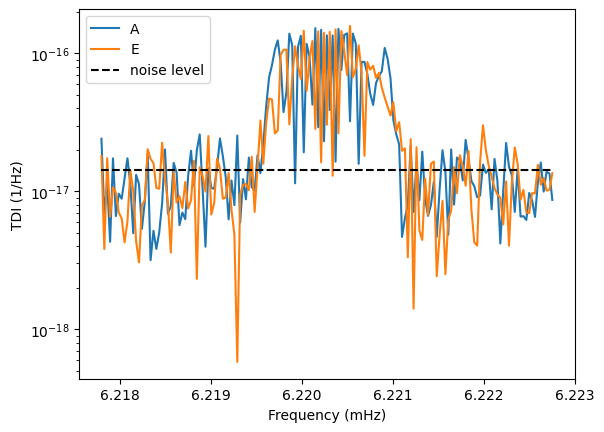

In [11]:
for i in range(len(data_channels_fd)):
    plt.semilogy(data_frequency*1e3, np.abs(data_channels_fd[i]), label=channel_names[i]) 
plt.hlines(np.sqrt(PSDlevel* Tobs / 2.), data_frequency[0]*1e3, data_frequency[-1]*1e3, colors="k", linestyles="--", label="noise level")
plt.xlabel("Frequency (mHz)")
plt.ylabel("TDI (1/Hz)")
plt.legend(loc="upper left")

## Waveform template model 

In [12]:
orbit = Orbit(OrbitDir=ORBIT_DIR)

X2_strings = TDIFly.X2_strings
Y2_strings = TDIStringManipulation.TDIStringCyc(X2_strings)
Z2_strings = TDIStringManipulation.TDIStringCyc(Y2_strings)

gb_tdifly_generator = TDIFlyGB(
    orbit=orbit, 
    Pstring_list=[X2_strings, Y2_strings, Z2_strings], 
    tcb_times=data_time.copy(), 
    Nsparse=512,
    use_gpu=False, 
)

## Rapid search 

### Set priors for the 4 parameters of $\mathcal{F}$-statistics
$A$, $\iota$, $\varphi_0$, $\psi$ are marginalized 

In [13]:
intrinsic_param_priors = np.array([
    [data_frequency[0], data_frequency[-1]], # f0
    [0., TDIFlyGB.fdot_upper_bound(data_frequency[0])], # fdot0, should also contain negative values for mass-transfer systems 
    [0, TWOPI], # longitude 
    [-1., 1.] # sin latitude 
])

### Search with DE algorithm 

In [14]:
from scipy.optimize import differential_evolution

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams), normalized to (0, 1)
    """
    int_params = norm_int_params * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nparams)
    params_in = TDIFlyGB.IntParamArr2Dict(int_params) # (Nparams) -> dictionary
    return -gb_tdifly_generator.Fstatistics(
        data=data_channels_fd, 
        intrinsic_parameters=params_in, 
        StartBound=band_idx[0]+1, 
        EndBound=band_idx[-1]+1, 
        Tobs=Tobs, 
        S=PSDlevel, 
        )[0] 

n_dim_int = 4
lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_result = differential_evolution(
    func=cost_function,
    bounds=bounds,
    x0=None,
    strategy='best1exp',
    maxiter=1000,
    popsize=5*n_dim_int, 
    tol=1e-6,
    atol=1e-8,
    mutation=(0.4, 0.95),
    recombination=0.7,
    disp=False,
    polish=False,
    workers=-1, 
)

print(DE_result)

/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


             message: Optimization terminated successfully.
             success: True
                 fun: -3506.1771592055284
                   x: [ 4.997e-01  9.849e-02  3.347e-01  4.528e-01]
                 nit: 77
                nfev: 6240
          population: [[ 4.997e-01  9.849e-02  3.347e-01  4.528e-01]
                       [ 4.997e-01  9.782e-02  3.347e-01  4.530e-01]
                       ...
                       [ 4.997e-01  9.819e-02  3.347e-01  4.529e-01]
                       [ 4.997e-01  9.827e-02  3.347e-01  4.533e-01]]
 population_energies: [-3.506e+03 -3.506e+03 ... -3.506e+03 -3.506e+03]


### Recover extrinsic parameters and waveform 
$\varphi_0$ and $\psi$ are multimodel and only one of the possible value is calculated here. It may not coincide with the truth, while this woundn't affect the astrophysical interpretation of this source and subsequent analysis.

In [15]:
searched_int_params = TDIFlyGB.IntParamArr2Dict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])
searched_a = gb_tdifly_generator.Fstatistics(
    data=data_channels_fd, 
    intrinsic_parameters=searched_int_params, 
    StartBound=band_idx[0]+1, 
    EndBound=band_idx[-1]+1, 
    Tobs=Tobs, 
    S=PSDlevel, 
    return_a=True, 
)
searched_ext_params = TDIFlyGB.a_to_extrinsic(searched_a)
searched_params = dict(searched_int_params, **searched_ext_params)

print("parameter name | true value | searched value | difference")
for k, v in searched_params.items(): 
    print(k, true_gb_parameters[k], v, np.abs(v-true_gb_parameters[k]))

parameter name | true value | searched value | difference
f0 0.0062202762350654 0.0062202754541783 7.808870997744188e-10
fdot0 7.4852687317337495e-16 8.00566683099859e-16 5.203980992648407e-17
longitude 2.102051345707588 2.102933942514338 0.0008825968067500689
latitude -0.0820999173027218 -0.09447349820101567 0.012373580898293865
A 4.252225600012621e-23 3.625653341281718e-23 6.265722587309032e-24
inclination 0.6632251157578452 0.3858534254875898 0.2773716902702554
psi 2.1242599437830183 3.0374221519023084 0.91316220811929
phase0 4.321297602415225 2.510090630235142 1.811206972180083


In [16]:
searched_wf = gb_tdifly_generator.Fstatistics(
    data=data_channels_fd, 
    intrinsic_parameters=searched_int_params, 
    StartBound=band_idx[0]+1, 
    EndBound=band_idx[-1]+1, 
    Tobs=Tobs, 
    S=PSDlevel, 
    return_recovered_wave=True, 
)[:, 0]
searched_wf.shape

(2, 157)

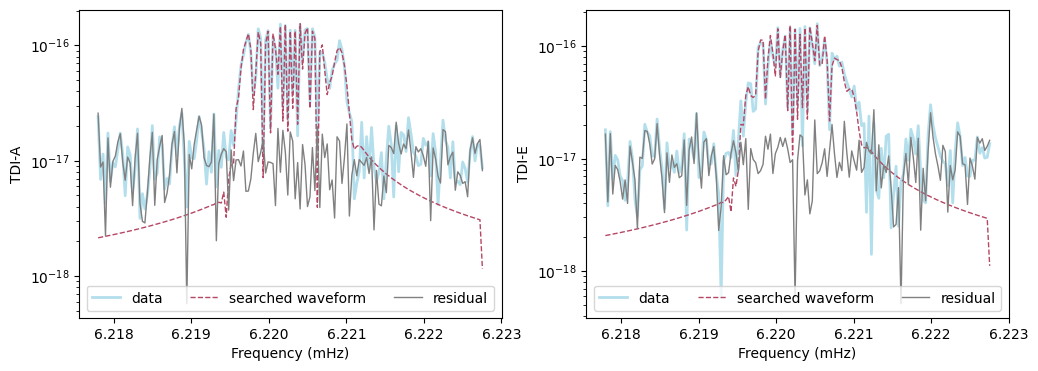

In [17]:
plt.figure(figsize=(12,4))
for i in range(len(data_channels_fd)):
    plt.subplot(121+i)
    plt.semilogy(data_frequency*1e3, np.abs(data_channels_fd[i]), label="data", color=BLUE, linewidth=2, alpha=0.5)
    plt.semilogy(data_frequency*1e3, np.abs(searched_wf[i]), label="searched waveform", color=RED, linewidth=1, linestyle="--")
    plt.semilogy(data_frequency*1e3, np.abs(searched_wf[i] - data_channels_fd[i]), label="residual", color="grey", linewidth=1)
    plt.xlabel("Frequency (mHz)")
    plt.ylabel("TDI-"+channel_names[i])
    plt.legend(loc="lower center", ncols=3)